In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
from google.colab import files
uploaded = files.upload()

Saving trafficViolation.zip to trafficViolation.zip


In [3]:
import zipfile
with zipfile.ZipFile("trafficViolation.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
import pandas as pd
df = pd.read_csv("Indian_Traffic_Violations.csv")
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Violation_ID               4000 non-null   object 
 1   Violation_Type             4000 non-null   object 
 2   Fine_Amount                4000 non-null   int64  
 3   Location                   4000 non-null   object 
 4   Date                       4000 non-null   object 
 5   Time                       4000 non-null   object 
 6   Vehicle_Type               4000 non-null   object 
 7   Vehicle_Color              4000 non-null   object 
 8   Vehicle_Model_Year         4000 non-null   int64  
 9   Registration_State         4000 non-null   object 
 10  Driver_Age                 4000 non-null   int64  
 11  Driver_Gender              4000 non-null   object 
 12  License_Type               4000 non-null   object 
 13  Penalty_Points             4000 non-null   int64

,Violation_ID,Violation_Type,Fine_Amount,Location,Date,Time,Vehicle_Type,Vehicle_Color,Vehicle_Model_Year,Registration_State,...,Speed_Limit,Recorded_Speed,Alcohol_Level,Breathalyzer_Result,Towed,Fine_Paid,Payment_Method,Court_Appearance_Required,Previous_Violations,Comments
0,VLT100000,Overloading,4544,Karnataka,2023-01-01,23:02,Car,Red,2012,West Bengal,...,100,95,0.03,Negative,Yes,No,Online,Yes,3,Repeat Offender
1,VLT100001,Driving Without License,2776,Punjab,2023-01-02,00:42,Scooter,Silver,2010,Tamil Nadu,...,40,48,0.45,Negative,Yes,Yes,Online,No,2,Repeat Offender
2,VLT100002,Using Mobile Phone,4785,Maharashtra,2023-01-03,04:32,Scooter,Grey,2006,Tamil Nadu,...,80,26,0.31,Not Conducted,No,No,Not Paid,Yes,4,NaN
3,VLT100003,No Seatbelt,1138,Uttar Pradesh,2023-01-04,15:06,Car,Green,1996,Uttar Pradesh,...,100,115,0.09,Not Conducted,No,Yes,Online,No,5,Repeat Offender
4,VLT100004,Over-speeding,1610,Karnataka,2023-01-05,06:57,Truck,Yellow,2016,Delhi,...,30,115,0.28,Positive,No,Yes,Cash,Yes,0,NaN


In [8]:
df['Helmet_Worn'] = df['Helmet_Worn'].fillna('Unknown')
df['Seatbelt_Worn'] = df['Seatbelt_Worn'].fillna('Unknown')

In [9]:
# STEP 4: Rule-based violation labeling
def is_violation(row):
    if row['Recorded_Speed'] > row['Speed_Limit']:
        return 1
    if row['Alcohol_Level'] > 0.25:
        return 1
    if row['Helmet_Worn'] == 'No' or row['Seatbelt_Worn'] == 'No':
        return 1
    if row['Traffic_Light_Status'] == 'Red' and row['Vehicle_Type'] in ['Car', 'Bike']:
        return 1
    return 0

df['violation'] = df.apply(is_violation, axis=1)

In [10]:
# STEP 5: Select important features
selected_features = [
    'Fine_Amount', 'Vehicle_Type', 'Vehicle_Color', 'Vehicle_Model_Year',
    'Driver_Age', 'Driver_Gender', 'License_Type', 'Penalty_Points',
    'Weather_Condition', 'Road_Condition', 'Helmet_Worn', 'Seatbelt_Worn',
    'Traffic_Light_Status', 'Speed_Limit', 'Recorded_Speed',
    'Alcohol_Level', 'Breathalyzer_Result', 'Previous_Violations'
]

X = df[selected_features]
y = df['violation']



In [13]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ("scale", StandardScaler(), numerical_cols)
])


In [14]:
# STEP 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)



In [15]:
# STEP 8: Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
rf_model.fit(X_train_proc, y_train)
rf_preds = rf_model.predict(X_test_proc)

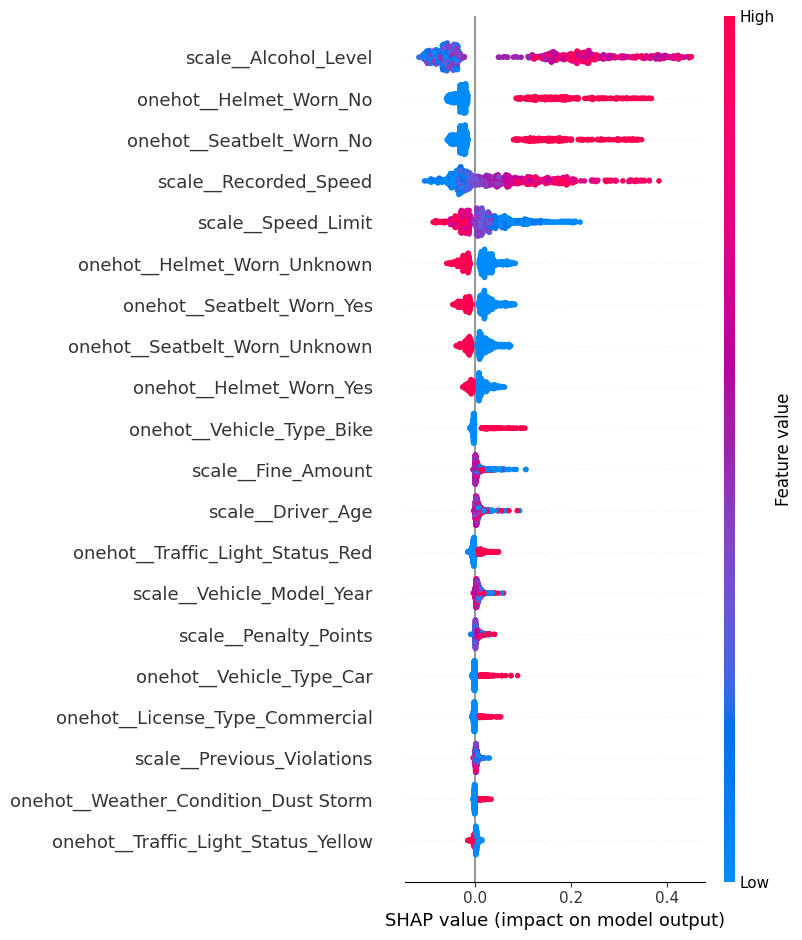

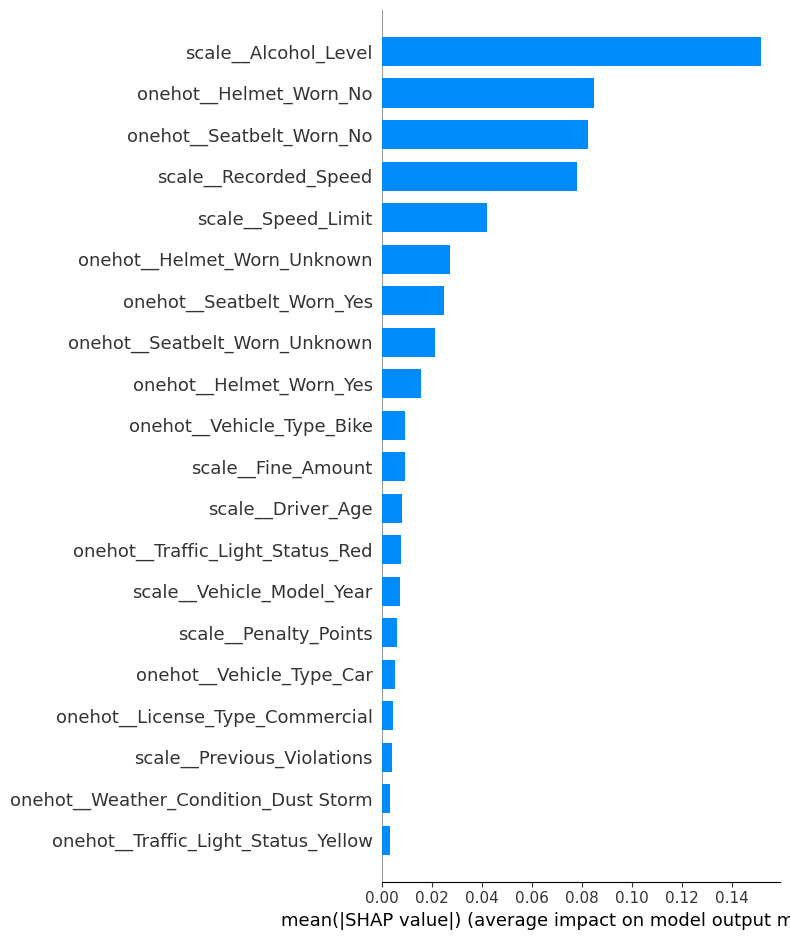

In [16]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_proc)  # shap_values shape: (samples, features, classes)

X_test_df = pd.DataFrame(X_test_proc, columns=preprocessor.get_feature_names_out())

# For class 1, extract correct slice:
shap_class_1 = shap_values[:, :, 1]

shap.summary_plot(shap_class_1, X_test_df)
shap.summary_plot(shap_class_1, X_test_df, plot_type="bar")


In [17]:
# STEP 10: Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n {name} ")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



 Random Forest 
Accuracy: 0.97375
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83        62
           1       0.99      0.99      0.99       738

    accuracy                           0.97       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.97      0.97      0.97       800



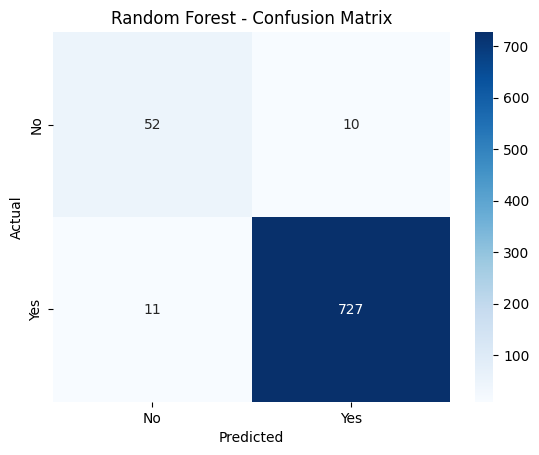

In [18]:
evaluate_model("Random Forest", y_test, rf_preds)

In [19]:
importances = rf_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
50,scale__Alcohol_Level,0.278798
49,scale__Recorded_Speed,0.145709
35,onehot__Seatbelt_Worn_No,0.126686
32,onehot__Helmet_Worn_No,0.126065
48,scale__Speed_Limit,0.051676
33,onehot__Helmet_Worn_Unknown,0.025081
37,onehot__Seatbelt_Worn_Yes,0.024656
36,onehot__Seatbelt_Worn_Unknown,0.022972
44,scale__Fine_Amount,0.020267
34,onehot__Helmet_Worn_Yes,0.019513


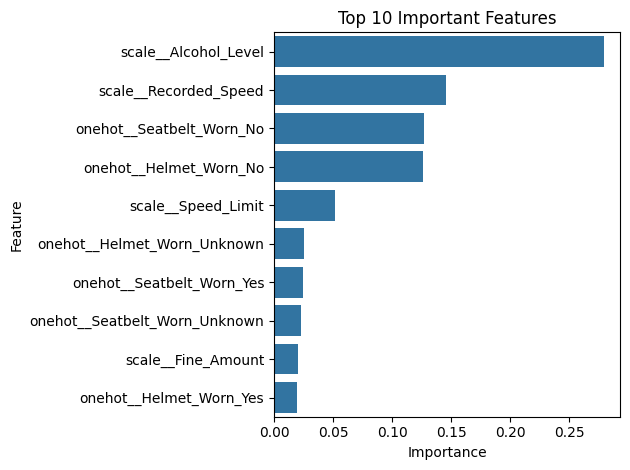

In [20]:
sns.barplot(x='Importance', y='Feature', data=feat_df.sort_values(by='Importance', ascending=False).head(10))
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()
